
# Diseño de software para cómputo científico

----

## Unidad 4: Optimización, paralelismo, concurrencia y cómputo distribuido en alto nivel.


### Profiling 

> Es la investigación del comportamiento de un programa de ordenador usando información reunida desde el análisis dinámico del mismo. 
> 
> El objetivo es averiguar el tiempo dedicado a la ejecución de diferentes partes del programa para detectar los puntos problemáticos y las áreas dónde sea posible llevar a cabo una optimización del rendimiento.

### Benchmark

> Es el resultado de la ejecución de un programa informático o un conjunto de programas en una máquina, con el objetivo de estimar el rendimiento de un elemento concreto, y poder comparar los resultados con máquinas similares. 

## Por qué hacemos profiling?

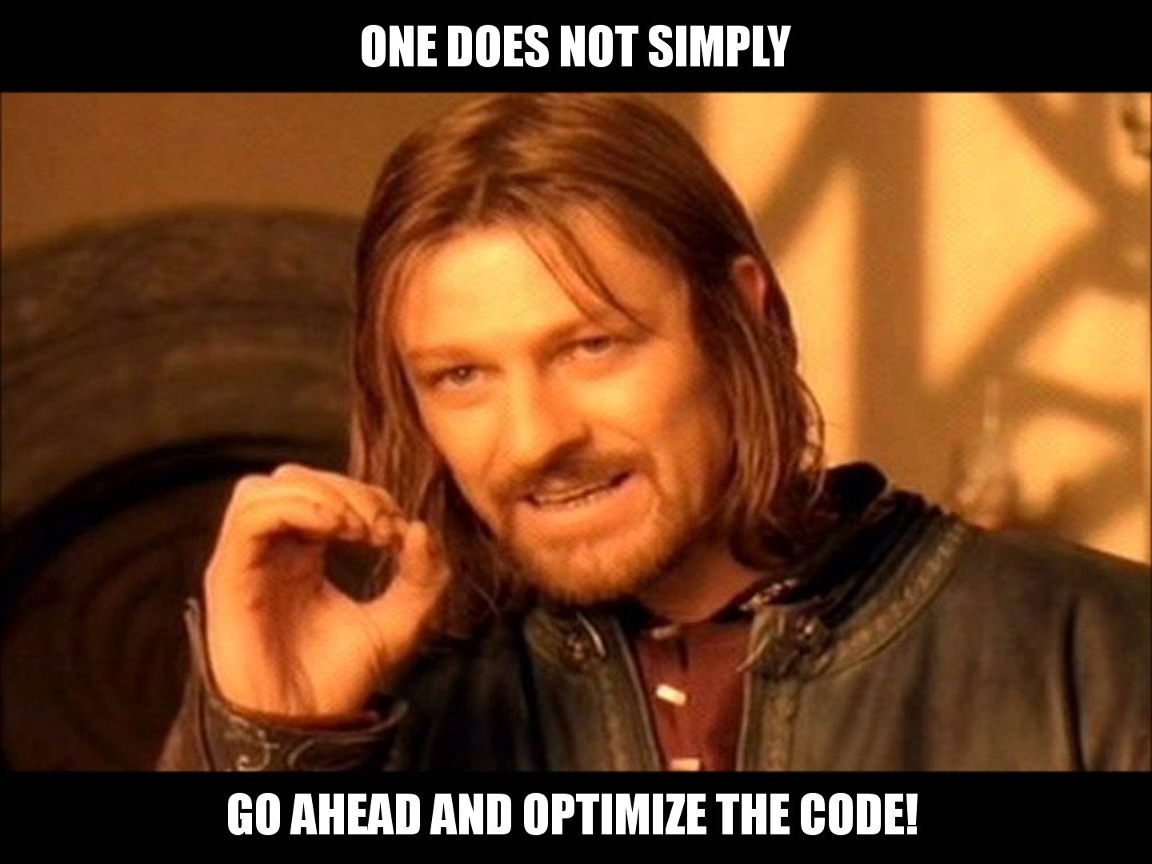

## Optimización responsable.


> "La optimización temprana es la raíz de todo mal."
>
>           Donald E. Knuth

1. ¿Cuánto del recurso $X$ se usa?
2. ¿Cómo se gasta exactamente esta cantidad de $X$?

$$X \in \{CPU, RAM, I/O, power, \dots \}$$

**¡Perfilamos el código para encontrar respuestas a estas preguntas!**

## Cuellos de botella

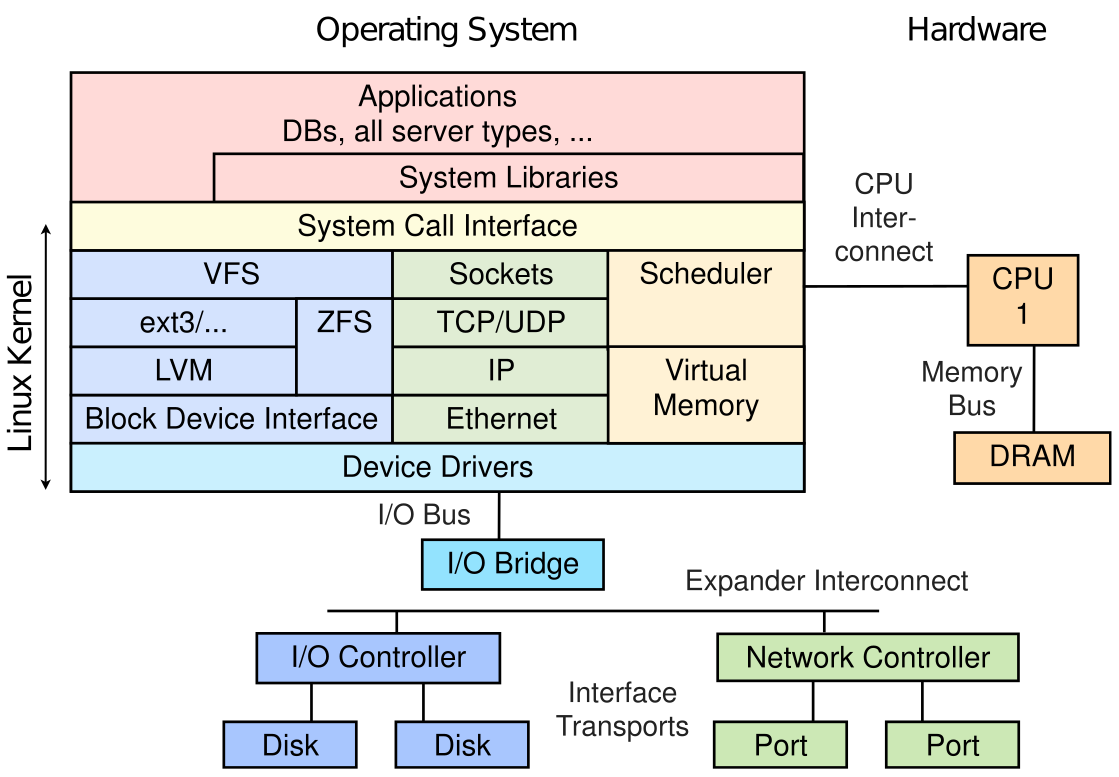

## Cuellos de botella

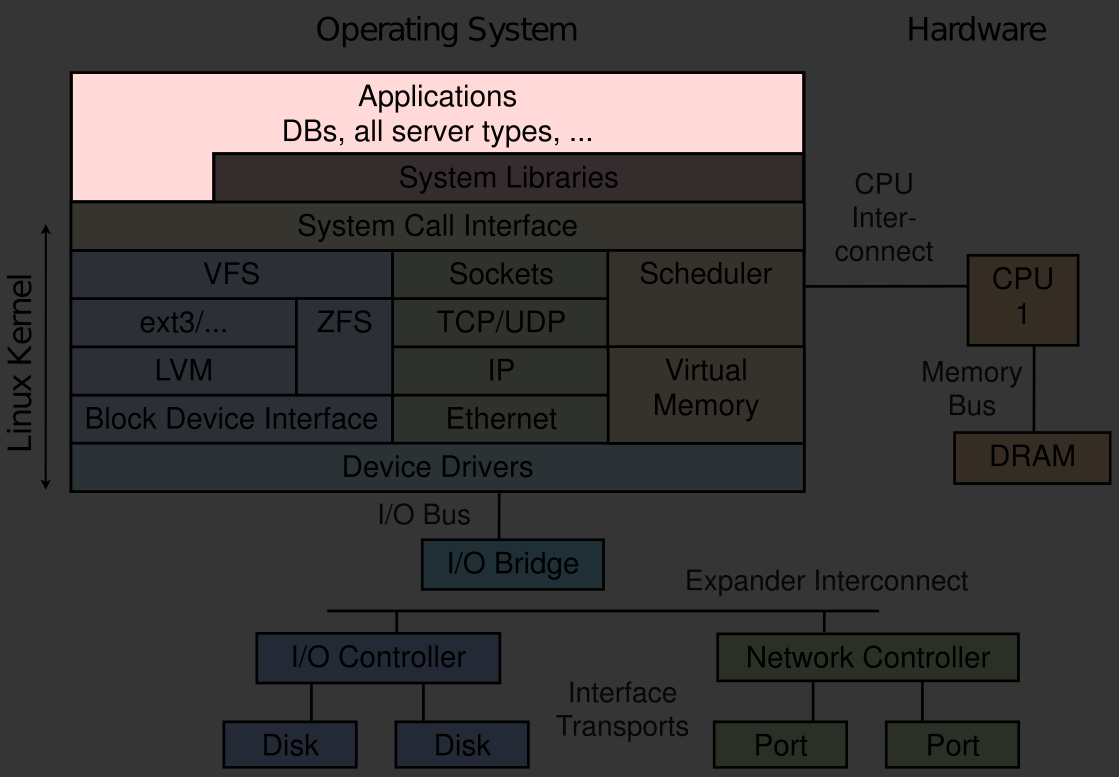

## Clasificación de herramientas de profiling

- **¿Qué se perfila?** - CPU, RAM, I/O, bandwith.
- **¿Cómo se perfila?** - Determinsta vs Estadístico.
- **¿Qué granularidad?** - Nivel de aplicación, Nivel de método/función, Nivel de línea.
- **Tipo de informe** - Texto, colores, call-graphs, Square-maps.

## Herramientas de profiling en Python

- **snippet-level:** `timeit` (stdlib)
- **Deterministic Method/Function-level:** `cProfile` y `profile` (stdlib).
- **Statistical Method/Function-level:** `statprof-smarkets` (pypi).
- **Run time, line-level, deterministic:** `line_profiler` (pypi).

- **Memory, line-level, ±deterministic:** `memory_profiler` (pypi)
- **Memory, method-level, deterministic:** `pympler` (pypi), `guppy3` (pypi).

## Herramientas "más" genéricas.

### Python extensions — use corresponding profilers!
- gprof (GCC)
- gperftools (Google)

### Generic or special-purpose profilers

- **Application-level, aggregate:** `time` (POSIX), `perf` (Linux)
- **Dynamic analysis with Valgrind:** `{Call,Cache}grind` / `Massif`

### High performance computing (HPC)

- **Measurement:** PAPI, Score-P, . . .
- **Analysis:** Vampir, TAU, Scalasca, . .

## Herramientas "más" genéricas.

### Python extensions — use corresponding profilers!
- gprof (GCC)
- gperftools (Google)

### Generic or special-purpose profilers

- **Application-level, aggregate:** **`time`** (POSIX), `perf` (Linux)
- **Dynamic analysis with Valgrind:** **`{Call,Cache}grind`** / `Massif`

### High performance computing (HPC)

- **Measurement:** PAPI, Score-P, . . .
- **Analysis:** Vampir, TAU, Scalasca, . .

## Empecemos con un ejemplo en caja negra con **time**

### printdf.py

El programa imprime por pantalla un dataframe en formato Pickle o *CSV*

```bash
$ time python printdf.py df.csv
...
real    0m2,318s
user    0m2,511s
sys     0m0,455s
```

```bash
$ time python printdf.py df.csv df.pkl
...
real   0m2,895s
user   0m5,387s
sys    0m0,656s
```

## Los secretos del *time*

- **real** es el tiempo del reloj de pared (de principio a fin de la llamada)
- **user** es la cantidad de tiempo de CPU gastado en código de modo de usuario
  (fuera del núcleo) dentro del proceso
- **sys** es la cantidad de tiempo de CPU que pasa en el núcleo (por ejemplo, en
    llamadas al sistema, asignación de memoria, E/S, etc.) dentro del proceso
- **user + sys** te dice cuánto tiempo de CPU real proceso consumido

$$
\Rightarrow real \ne user + sys
$$

## Microbenchmarks con `timeit`

In [15]:
def fib1(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

def fib2(n):
    if n > 1:
        return fib(n - 1) + fib(n - 2)
    else:
        return n

## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib2.py**

In [16]:
%timeit fib1(35)

1.53 µs ± 33.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [17]:
%timeit -n 3 fib2(35)

3.29 µs ± 339 ns per loop (mean ± std. dev. of 7 runs, 3 loops each)


## Microbenchmarks con `timeit` - Mejoramos **fib2.py**

**fib3.py**

In [8]:
def fib3(n, m={0: 0, 1: 1}):
    if n not in m:
        m[n] = fib(n - 1) + fib(n - 2)
    return m[n]

In [9]:
%timeit fib1(35)

1.53 µs ± 22.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%timeit fib3(35)

112 ns ± 1.32 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib3.py** (Detalle 1/2)

```bash 
$ python -m timeit -v -s 'from fib1 import fib' 'fib(35)'
1 loop -> 4.55e-06 secs
2 loops -> 1.67e-05 secs
5 loops -> 8.63e-06 secs
10 loops -> 1.56e-05 secs
...
20000 loops -> 0.0297 secs
50000 loops -> 0.0756 secs
100000 loops -> 0.145 secs
200000 loops -> 0.286 secs

raw times: 296 msec, 288 msec, 283 msec, 282 msec, 283 msec

200000 loops, best of 5: 1.41 usec per loop
```


## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib3.py** (Detalle 2/2)

```bash 
$ python -m timeit -v -s 'from fib3 import fib' 'fib(35)'
1 loop -> 1.56e-05 secs
2 loops -> 8.49e-07 secs
5 loops -> 8.77e-07 secs
10 loops -> 1.39e-06 secs
20 loops -> 2.56e-06 secs
50 loops -> 6.05e-06 secs
...
20000 loops -> 0.00249 secs
50000 loops -> 0.00581 secs
100000 loops -> 0.0126 secs
200000 loops -> 0.0235 secs
500000 loops -> 0.065 secs
1000000 loops -> 0.119 secs
2000000 loops -> 0.236 secs

raw times: 232 msec, 228 msec, 236 msec, 235 msec, 229 msec

2000000 loops, best of 5: 114 nsec per loop
```


Es importante fijarse que se mide **lo que se quiere medir**

## Microbenchmarks con `timeit` - -- Closed form solution!


**fib4.py**
```python
import math

sqrt5 = math.sqrt(5)
phi = (1 + sqrt5) / 2

def fib(n):
    return int((phi ** n - (-phi) ** -n) / sqrt5)
```

## Microbenchmarks con timeit - fib1.py Vs. fib4.py

```bash
$ python -m timeit -s 'from fib1 import fib' 'fib(70)'
100000 loops, best of 5: 2.86 usec per loop

$ python -m timeit -s 'from fib4 import fib' 'fib(70)'
1000000 loops, best of 5: 309 nsec per loop
```


## Microbenchmarks con timeit - fib1.py Vs. fib4.py - CMP

```bash
$ python -c 'from fib1 import fib; print(fib(70), fib(80))'
190392490709135 23416728348467685

$ python -c 'from fib4 import fib; print(fib(70), fib(80))'
190392490709135 23416728348467744
```

**Que halgo funcione rapido no significa que funcione bien**

## Metod level Profiling 

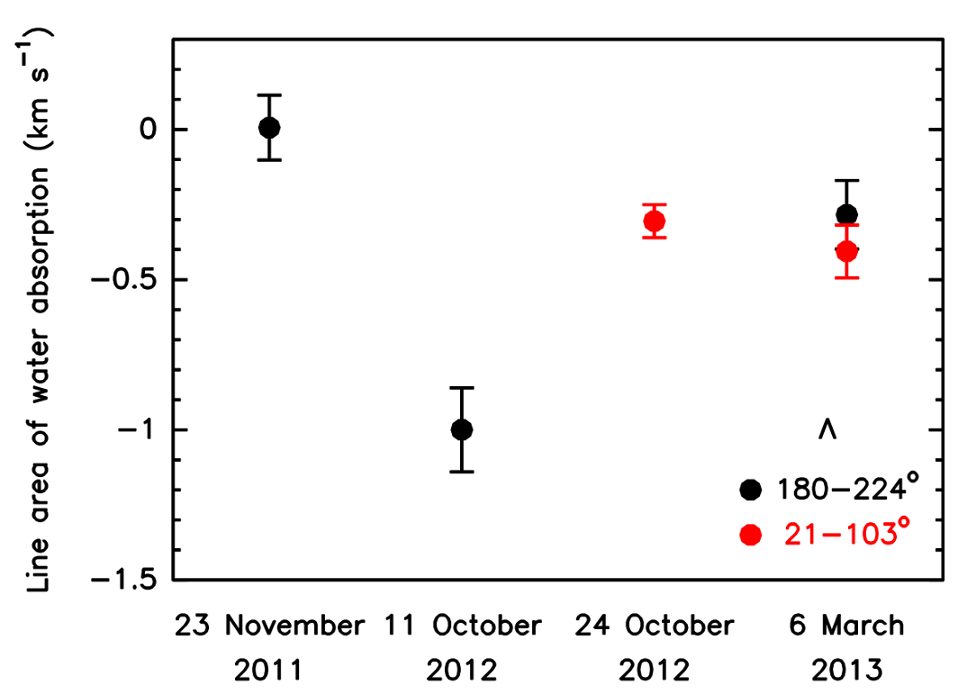

>Küppers et al., “Localized sources of water vapour on the dwarf planet (1) Ceres”, Nature 505, 525–527, 23 January 2014

## Metod level Profiling

### Intervalos de confianza via pivotal quantities

Intervalo de confianza com media  $\bar{X}=500$ of dataset $X={x_i}$:

$$
\bar{x} \pm z_{\alpha}, z_{\alpha}=?, p=95\%, x_{i} \in [0, 1000], i = 1 \dots 10^5
$$

En peudo-código seria:

1. Generar una conjunto grande de "medidas" de $X$ (valores)
2. Tratar de encontrar el `confidence_interval()` para $\alpha=100\%-p=5\%$ en pocas iteraciones (`try_iterations > 10`), tolerando una `variance_threshold = 0.5` en `trials = 5` intentos.

**Antes de ponernos a entender bien el código empecemos como caja negra.**

## Metod level Profiling

## Black box analysis

```bash
$ time -p python confidence.py
10 0.008265762717221986
500.12754666666666 ((499.3288933333333, 500.4133333333333), 10)

real 35,39
user 34,93
sys 0,43
```

Es importante que si tenemos un **sys** alto probablemente estemos escribiendo archivos a disco mal

**DETALLITO** Python 3.8

```
real 45,55
user 45,07
sys 0,38
```

## Metod level Profiling

### Bueno esto es lento: a ver el código.

- `def adaptive_confidence_interval(...):`
    1. Se empieza con `try_iterations = 10` iteraciones.
    2. Se calculan `trials = 5` intentos de `confidence_interval()`.
    3. `variance < 0.5`, o si las alcanzamos `max_iterations = 1000`? 
        - **True** -> Done!.
        - **False** -> `try_iterations *= 2`.

- `def confidence_interval(values, iterations, alpha):`
    1. Tomamos `iterations` muestras de `values`.
    2. Computamos de cada muestra $\bar{x}'$ y ordeamos los resultados.
    3. Retornamos los límites.

**Mirando el código: Donde creen que se gasta mas tiempo?**

## Metod level Profiling

```bash
$ python -m cProfile -s cumulative confidence.py
10 0.008265762717221986
500.12754666666666 ((499.3288933333333, 500.4133333333333), 10)
         205442867 function calls (205442845 primitive calls) in 69.312 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      3/1    0.000    0.000   69.312   69.312 {built-in method builtins.exec}
        1    0.007    0.007   69.312   69.312 confidence.py:1(<module>)
        1    0.000    0.000   69.304   69.304 confidence.py:54(main)
        1    0.000    0.000   68.351   68.351 confidence.py:37(adaptive_confidence_interval)
        1    0.073    0.073   68.351   68.351 confidence.py:43(<listcomp>)
        5    0.585    0.117   68.279   13.656 confidence.py:19(confidence_interval)
       50   12.690    0.254   61.933    1.239 confidence.py:24(<listcomp>)
 30600001    8.867    0.000   47.363    0.000 random.py:334(randint)
 30600001   16.738    0.000   38.497    0.000 random.py:290(randrange)
 30600001   14.989    0.000   21.759    0.000 random.py:237(_randbelow_with_getrandbits)
       50    4.764    0.095    4.764    0.095 confidence.py:25(<listcomp>)
       
 ...
```

**Profilers add overhead**

## Gran lección sobre profiling

**Tu intuición esta (probablemente) MAL**

## Metod level Profiling - Visualicación

1. `$ python -m cProfile -o confidence.cProfile-1 -s cumulative confidence.py`
2. `$ sudo apt-get install kcachegrind`
3. `$ pip install pyprof2calltree`

1. `$ pyprof2calltree -i confidence.cProfile-1 -o cachegrind.out.1`
2. `$ kcachegrind cachegrind.out.1`

## OR

3. `$ pyprof2calltree -i confidence.cProfile-1 -k`




## Metod level Profiling - Mejorando el código

```diff
$ diff -BurpN confidence.py confidence-2.py
--- confidence.py	2019-10-20 21:45:36.445858051 -0300
+++ confidence-2.py	2019-10-20 22:16:34.709665842 -0300
@@ -1,5 +1,5 @@
-import random
+import numpy as np
 def mean(values):
@@ -28,7 +28,7 @@ def adaptive_confidence_interval(values,     
-            return intervals[random.randint(0, trials - 1)], try_iterations
+            return intervals[np.random.randint(0, trials)], try_iterations
@@ -38,7 +38,7 @@ def confidence_interval(values, iteratio   
-        subsample_indices = [random.randint(0, len(values) - 1) for _ in range(len(values))]
+        subsample_indices = list(np.random.randint(0, len(values), len(values)))
@@ -52,8 +52,8 @@ def confidence_interval(values, iteratio
 def main(sample_size):
-    random.seed(12345)
-    values = [random.randint(0, 1000) for _ in range(sample_size)]
+    np.random.seed(12345)
+    values = list(np.random.randint(0, 1000+1, size=sample_size))
     print(mean(values), adaptive_confidence_interval(values))
```


## Metod level Profiling - Mejorando el código

### Black box analysis

```bash
$ time -p python confidence.py 
10 0.008265762717221986
500.12754666666666 ((499.3288933333333, 500.4133333333333), 10)

real 35,39
user 34,93
sys 0,43
```

```bash
$ time -p python confidence-2.py
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)
real 11,46
user 11,38
sys 0,74
```

**No todos los RNGs son iguales.**

## Method level profiling - Mejorando el código

### Visualizamos denuevo

1. `$ python -m cProfile -o confidence-2.cProfile-1 confidence-2.py`
2. `$ pyprof2calltree -i confidence-2.cProfile-1 -o -k`

## Line profile

```bash
$ pip install line_profiler
```

- Si esa instalacción falla fijarse en: https://github.com/pyutils/line_profiler
- Probablemente tengan que recargar el virtualenv para que todo funcione

### Cambios en el código

```diff
$ diff -BurpN confidence-2.py confidence-3.py
--- confidence-2.py	2019-10-20 22:16:34.709665842 -0300
+++ confidence-3.py	2019-10-20 23:20:34.905923637 -0300
@@ -32,7 +32,7 @@ def adaptive_confidence_interval(values,
         try_iterations *= 2
-
+@profile
 def confidence_interval(values, iterations, alpha):
     """ Compute confidence interval of mean """
```

## Line profile - Blackbox

```bash
$ time -p python confidence-2.py
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)

real 11,46
user 11,38
sys 0,74
```

```bash
$ time -p kernprof -l -o confidence-3.py.lprof confidence-3.py
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)
Wrote profile results to confidence-3.py.lprof

real 14,36
user 14,33
sys 0,77
```

## Line profile - Mirando resultados

```bash
$ python -m line_profiler confidence-3.py.lprof
Timer unit: 1e-06 s
Total time: 13.7873 s
File: confidence-3.py
Function: confidence_interval at line 35

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    35                                           @profile
    36                                           def confidence_interval(values, iterations, alpha):
    37                                               """ Compute confidence interval of mean """
    39         5         16.0      3.2      0.0      subsample_means = []
    40        55        165.0      3.0      0.0      for _ in range(iterations):
    41        50    1740387.0  34807.7     12.6          subsample_indices = list(np.random.randint(0, ...
    42        50    8317412.0 166348.2     60.3          subsample_values = [values[idx] for idx in ...
    43        50    3498978.0  69979.6     25.4          subsample_means.append(mean(subsample_values))
    44         5         16.0      3.2      0.0      subsample_means.sort()                                 
    46         5         27.0      5.4      0.0      lower_index = int(math.floor(iterations * (1 - ...
    47         5          7.0      1.4      0.0      upper_index = int(math.floor(iterations * alpha / 2))
    49         5          9.0      1.8      0.0      pivot = lambda idx: (2 * mean(values) - ...
    51         5     230309.0  46061.8      1.7      return pivot(lower_index), pivot(upper_index)
```

## Line profile - Mejorando

```diff
$ diff -BurpN confidence-3.py confidence-4.py
--- confidence-3.py	2019-10-20 23:20:34.905923637 -0300
+++ confidence-4.py	2019-10-20 23:47:57.449073343 -0300
@@ -32,14 +32,13 @@ def adaptive_confidence_interval(values,
 
         try_iterations *= 2
 
-@profile
+
 def confidence_interval(values, iterations, alpha):
     """ Compute confidence interval of mean """
 
     subsample_means = []
     for _ in range(iterations):
-        subsample_indices = list(np.random.randint(0, len(values), len(values)))
-        subsample_values = [values[idx] for idx in subsample_indices]
+        subsample_values = list(np.random.choice(values, len(values)))
         subsample_means.append(mean(subsample_values))
     subsample_means.sort()
```

## Line profile - Mejorando

```bash
$ time -p python confidence-2.py
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)

real 11,46
user 11,38
sys 0,74
```

```bash
$ time -p python confidence-4.py 
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)

real 4,77
user 4,86
sys 0,65
```

**Profile a nivel Método no es siempre suficiente**

## Line profile - Problema

Me gustaria tener los mismos datos pero no con tranto overhead

```bash
$ pip install statprof-smarkets
```

En vez de medir cada linea toto el tiempo, frenemos la ejecución de ves en cuando y veamos que esta sucediendo.

## Stats profile

```diff
$ diff -BurpN confidence-3.py confidence-5.py
--- confidence-3.py	2019-10-20 23:20:34.905923637 -0300
+++ confidence-5.py	2019-10-21 00:24:04.171545426 -0300
@@ -32,7 +32,7 @@ def adaptive_confidence_interval(values,
 
         try_iterations *= 2
 
-@profile
+
 def confidence_interval(values, iterations, alpha):
     """ Compute confidence interval of mean """
 
@@ -59,4 +59,7 @@ def main(sample_size):
 
 if __name__ == '__main__':
     N = 600_000
-    main(N)
+
+    import statprof
+    with statprof.profile():
+        main(N)
```

## Stats profile

```bash
$ python confidence-5.py 
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)
  %   cumulative      self          
 time    seconds   seconds  name    
 76.02      8.51      8.51  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:42:<listcomp>
 11.31      1.27      1.27  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:41:confidence_interval
  6.90      0.77      0.77  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:7:mean
  5.09      1.20      0.57  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:43:confidence_interval
  0.57     11.16      0.06  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:25:<listcomp>
  0.11      0.01      0.01  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:56:main
  0.00     11.19      0.00  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:65:<module>
  0.00     11.18      0.00  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:57:main
  0.00      0.13      0.00  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:49:<lambda>
  0.00      0.13      0.00  /home/juan/proyectos/dis_ssw/src/unidad4/cProfile/confidence-5.py:51:confidence_interval
---
Sample count: 884
Total time: 11.190000 seconds
```

## Y con la memoria que?

- La opción por defecto es `memory_profiler`
- Se usa igual que `line_profiler`
- Es lento 

```bash
$ pip install memory_profiler psutil
```

Instalar siempre **psutil** para lograr velocidad

## Profile de memoria


```bash
$ time python -m memory_profiler confidence-3.py
10 0.03784639008138585
500.07785 ((499.65447, 500.46533833333336), 10)
Filename: confidence-3.py

Line #    Mem usage    Increment  Occurences   Line Contents
============================================================
    35   80.801 MiB  -75.828 MiB           5   @profile
    36                                         def confidence_interval(values, iterations, alpha):
    37                                             """ Compute confidence interval of mean """
    39   80.801 MiB  -15.094 MiB           5       subsample_means = []
    40  117.492 MiB -218.879 MiB          55       for _ in range(iterations):
    41  117.492 MiB -184.699 MiB          50           subsample_indices = list(np.random.randint(0, ...
    42  117.492 MiB -134702312.918 MiB    30000150     subsample_values = [values[idx] for idx in ...
    43  117.492 MiB -208.355 MiB          50           subsample_means.append(mean(subsample_values))
    44  114.770 MiB  -16.191 MiB           5       subsample_means.sort()
    46  114.770 MiB   -2.578 MiB           5       lower_index = int(math.floor(iterations * (1 - alpha ...
    47  114.770 MiB   -2.578 MiB           5       upper_index = int(math.floor(iterations * alpha / 2))
    49  114.770 MiB  -12.891 MiB          25       pivot = lambda idx: (2 * mean(values) - ...
    51  114.770 MiB   -2.578 MiB           5       return pivot(lower_index), pivot(upper_index)

real	29m2,396s
user	22m19,301s
sys	6m32,995s
```


## Summary re. benchmarking

- Usar herramientas standard (timeit, time, etc.)
- Tener cuidado con la interferencia en todos los niveles
    - Background tasks in multiuser environment
    - CPU frequency scaling (TurboBoost, etc.)
    - Cold / hot caches of various subsystems
- Repetir el experimento muchas veces!!!

**Un benchmarking bien hecho es CARO, evitarlo!**

## Summary re. performance optimization

- Usar profiling *for fun and profit*, NUNCA confiar en la intuición.
- Los profilers a nivel app o sistema son sumamente útiles.
- Saber cuando parar (Ley de rendimientos decrecientes/Ley de pareto)
- Pensar unas 37 veces antes de aplicar profiling en producción (overhead!)
- Seguir **alguna** metodología: http://www.brendangregg.com/methodology.html

## Referencias

- https://www.youtube.com/watch?v=DUCMjsrYSrQ
- http://zaytsev.net/confidence-2.zip
- https://es.wikipedia.org/wiki/An%C3%A1lisis_de_rendimiento_de_software
- https://es.wikipedia.org/wiki/Benchmark_(inform%C3%A1tica)
- http://www.brendangregg.com/linuxperf.html